### **Media Prediction**
[MediaDive] to [KEGG, UniProt OR BacDive] to [Downstream applications]

In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from io import StringIO

import os
DATA_DIR = '~/Desktop/code/data/'

from Bio.KEGG import REST
import bacdive

import requests
import re
from requests.adapters import HTTPAdapter, Retry

from matplotlib import pyplot as plt

### MediaDive Table Creation

This table contains all information (media id's, components, component id's, characteristics, associated taxa information, etc.) used for subsequent analyses.

In [2]:
import modules.mediadive as md

**[1] Retrieve all MediaDive info** (skip to [3] after first time)

In [3]:
# Get all info for available media on MediaDive
md_media_df = md.get_media()
# Format and save media information to data directory
md_media_df = md_media_df.rename(columns={"id": "media_id"})
md_media_df.to_csv(os.path.join(DATA_DIR,"mediadive", "mediadive-media.csv"), index=False)

# Put media to list
media_id_list = md_media_df["media_id"].astype(str).unique()

# Use media_id_list to retrieve media composition information
md_comp_df = md.get_composition(media_id_list)
md_comp_df.to_csv(os.path.join(DATA_DIR, "mediadive","mediadive-media-comp.csv"), sep=";", index=False)
    #TO-DO: parse information for complex media ingredients to also retrieve those components

# Use media_id_list to retrieve media-associated strain information
md_strains_df = md.get_strains(media_id_list)
md_strains_df.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-media-strains.csv"), sep=";", index=False)

100%|██████████| 3315/3315 [09:17<00:00,  5.95it/s]


**[2] Merge MediaDive outputs**

In [4]:
# Merge media composition and strains info
md_df = pd.merge(left=md_comp_df, right=md_strains_df, on="media_id", how="outer", indicator=True)
# Merge media information with previous data
md_df = pd.merge(left=md_media_df, right=md_df, on="media_id", how="left", indicator=False)

# Add extra column indicating the source of the data
md_df = md_df.rename(columns={"_merge": "merge_source"})
md_df["merge_source"] = md_df["merge_source"].cat.rename_categories({"right_only": "composition_only", "left_only": "strains_only"})

# Save our final dataframe
md_df.to_csv(os.path.join(DATA_DIR,"mediadive","mediadive-all.csv"), sep=";", index=False)

**[3] Final MediaDive dataframe**

In [13]:
md_df = pd.read_csv(os.path.join(DATA_DIR,"mediadive","mediadive-all.csv"), sep = ';')
md_df

,media_id,name,complex_medium,source,link,min_pH,max_pH,reference,description,components,component_ids,strain_id,species,ccno,bacdive_id,merge_source
0,1,NUTRIENT AGAR,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",29.0,Comamonas testosteroni,DSM 38,2912.0,both
2,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",30.0,Delftia acidovorans,DSM 39,2941.0,both
3,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",39.0,Acidovorax delafieldii,DSM 64,2885.0,both
4,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",52.0,Pseudomonas putida,DSM 84,12895.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31897,P5,RS Medium - Nutrient Medium (NM) Component,1,public,NaN,7.0,7.0,NaN,The RS medium is a fully defined medium design...,[],[],NaN,NaN,NaN,NaN,strains_only
31898,P6,mTA10,1,public,NaN,7.2,7.2,10.1016/j.foodcont.2012.06.029,NaN,[],[],NaN,NaN,NaN,NaN,strains_only
31899,P7,N27 RHODOSPIRILLACEAE MEDIUM (modified),1,public,NaN,6.8,6.8,NaN,NaN,[],[],NaN,NaN,NaN,NaN,strains_only
31900,P8,M9-SNG medium,1,public,NaN,7.2,7.2,10.1007/s11104-022-05822-6,Myrosinase producing bacteria and fungi enric...,[],[],NaN,NaN,NaN,NaN,strains_only


In [6]:
import plotly.express as px
# Plot the occurrence of enzymes across all of our selected taxa 
fig = px.bar(
    data_frame = md_df.value_counts('species').head(200).reset_index(),
    x="species",
    y="count",
    
    title="Strain count by species (Top 200)"
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.show()

### BacDive taxa2ec (bacdive_id)

This table returns ec numbers, environmental info, metabolite data, taxonomic information, culturing info, and more based on an input of bacdive id's

In [7]:
import modules.bacdive as bd

**[1] Initializing BacDive** (skip to [3] after first time)

In [8]:
# Read MediaDive master table to retrieve bacdive strain id's
md_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-all.csv"), sep=";")
# Make bacdive strain id's into a list
bd_id_list = md_df["bacdive_id"].dropna().astype(int).astype(str).unique()
bd_id_list

array(['2912', '2941', '2885', ..., '159029', '158241', '131423'],
      dtype=object)

In [9]:
len(bd_id_list)

13735

**[2] Retrieval of BacDive info** 

In [10]:
# Initialize client
client = bacdive.BacdiveClient('wjlowe03@gmail.com', 'UNINA_Bacdive')

step = 100
bacdive_df = []

for idx_start in tqdm(range(0, len(bd_id_list), step)): #status bar
    id_list = ";".join(bd_id_list[idx_start:idx_start+step]) 
    bacdive_df.append(bd.taxon2ec(id_list=id_list, client=client))

bacdive_df = pd.concat(bacdive_df, axis=0, ignore_index=True)
bacdive_df = bacdive_df.drop("reference", axis=1)

bacdive_df.to_csv(os.path.join(DATA_DIR, "bacdive", "bacdive-all.csv"), index=False)
bacdive_df.head()

-- Authentication successful --


100%|██████████| 138/138 [04:03<00:00,  1.76s/it]


,general_@ref,bacdive_id,dsmz_id,general_keywords,general_description,taxon_id,ncbi_tax_id_matching_level,strain_history_@ref,strain_history_history,general_doi,...,api_id32sta_beta_gur,physiology_and_metabolism_murein,physiology_and_metabolism_api_list,isolation_enrichment_culture,isolation_enrichment_culture_temperature,multicellular_morphology_complex_color,api_list_beta_hem,metabolite_tests_citrate_test,compound_production_excreted,isolation_enrichment_culture_duration
0,21113,24370,11532.0,"[Bacteria, human pathogen]",Pseudomonas fluorescens PWD34 is a human patho...,294,species,21113.0,"<- W. Duetz, RIVM, Bilthoven; PWD34",10.13145/bacdive24370.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21111,24368,304.0,Bacteria,Pseudomonas sp. DSM 304 is a bacterium of the ...,306,species,21111.0,"<- IMG, 1591 (<i>P. fluorescens</i>) <- H. Stolp",10.13145/bacdive24368.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20542,23995,30059.0,Bacteria,Lelliottia amnigena 21824 is a bacterium that ...,61646,species,20542.0,<- Bakteriologisches Institut der Sueddeutsche...,10.13145/bacdive23995.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1479,17621,3849.0,"[16S sequence, Bacteria, plant pathogen]",Xanthomonas citri subsp. malvacearum XM13 is a...,346,species,NaN,NaN,10.13145/bacdive17621.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1480,17596,3850.0,"[genome sequence, Bacteria, obligate aerobe, G...",Xanthomonas campestris DSM 3850 is an obligate...,339,species,NaN,NaN,10.13145/bacdive17596.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**[3] Final BacDive dataframe**

In [17]:
bacdive_df = pd.read_csv('~/Desktop/code/data/bacdive/bacdive-all.csv', low_memory=False)
bacdive_df.head()

,general_@ref,bacdive_id,dsmz_id,general_keywords,general_description,taxon_id,ncbi_tax_id_matching_level,strain_history_@ref,strain_history_history,general_doi,...,api_id32sta_beta_gur,physiology_and_metabolism_murein,physiology_and_metabolism_api_list,isolation_enrichment_culture,isolation_enrichment_culture_temperature,multicellular_morphology_complex_color,api_list_beta_hem,metabolite_tests_citrate_test,compound_production_excreted,isolation_enrichment_culture_duration
0,21113,24370,11532.0,"['Bacteria', 'human pathogen']",Pseudomonas fluorescens PWD34 is a human patho...,294,species,21113.0,"<- W. Duetz, RIVM, Bilthoven; PWD34",10.13145/bacdive24370.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21111,24368,304.0,Bacteria,Pseudomonas sp. DSM 304 is a bacterium of the ...,306,species,21111.0,"<- IMG, 1591 (<i>P. fluorescens</i>) <- H. Stolp",10.13145/bacdive24368.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20542,23995,30059.0,Bacteria,Lelliottia amnigena 21824 is a bacterium that ...,61646,species,20542.0,<- Bakteriologisches Institut der Sueddeutsche...,10.13145/bacdive23995.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1479,17621,3849.0,"['16S sequence', 'Bacteria', 'plant pathogen']",Xanthomonas citri subsp. malvacearum XM13 is a...,346,species,NaN,NaN,10.13145/bacdive17621.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1480,17596,3850.0,"['genome sequence', 'Bacteria', 'obligate aero...",Xanthomonas campestris DSM 3850 is an obligate...,339,species,NaN,NaN,10.13145/bacdive17596.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### UniProtKB taxa2ec (species name)

This table returns ec numbers and identifier information for an input of species

In [12]:
import modules.uniprotkb as uni

**[1] Format species name from the md_df MediaDive table for querying UniProtKB** (skip to [3] after first time)

In [13]:
species_df = md_df.copy()
species_df['species'] = species_df['species'].replace(' ','+', regex=True)
species_list = set(species_df['species'].to_list())
len(species_list)

12391

**[2] Retrieval of UniProtKB info**

In [14]:
# Import and run function to retrieve ec's associated with each species
    # Note: currently, script only checks reviewed entries (SwissProt), and ignores 1000's of tREMBL entries
    # Errors represent where species are totally absent, whereas non-reviewed entries show as 'x species with no data'
    
uniprot_df = uni.species2ec(species_list)

uniprot_df.to_csv(os.path.join(DATA_DIR, "uniprot", "uniprot-all.csv"), index=False)

Processing species:  21%|██▏       | 2635/12391 [05:53<13:21, 12.18it/s]  

HTTP error occurred for Sphingobacterium+composti+[homonym]: 400 Client Error: Bad Request for url: https://rest.uniprot.org/uniprotkb/search?fields=accession%2Cec%2Corganism_name%2Corganism_id%2Ccc_cofactor%2Cid&format=tsv&size=500&query=%28organism_name%3ASphingobacterium+composti+%5Bhomonym%5D%29+AND+%28ec%3A*%29+AND+%28reviewed%3Atrue%29


Processing species:  84%|████████▎ | 10364/12391 [22:29<03:27,  9.78it/s] 

HTTP error occurred for Protocrea+illino&euml;nsis: 400 Client Error: Bad Request for url: https://rest.uniprot.org/uniprotkb/search?fields=accession%2Cec%2Corganism_name%2Corganism_id%2Ccc_cofactor%2Cid&format=tsv&size=500&query=%28organism_name%3AProtocrea+illino&euml;nsis%29+AND+%28ec%3A*%29+AND+%28reviewed%3Atrue%29


Processing species: 100%|██████████| 12391/12391 [26:43<00:00,  7.73it/s]


10660 species with no data


,species,ec_uniprot
0,Ruminiclostridium+josui,1.2.1.70; 1.3.1.76; 4.99.1.4
1,Ruminiclostridium+josui,2.5.1.61
2,Ruminiclostridium+josui,2.1.1.107; 4.2.1.75
3,Ruminiclostridium+josui,4.2.1.24
4,Ruminiclostridium+josui,3.2.1.4


**[3] Final UniProtKB dataframe**

In [8]:
uniprot_df = pd.read_csv('~/Desktop/code/data/uniprot/uniprot-all.csv')
uniprot_df.head()

,species,ec_uniprot
0,Ruminiclostridium+josui,1.2.1.70; 1.3.1.76; 4.99.1.4
1,Ruminiclostridium+josui,2.5.1.61
2,Ruminiclostridium+josui,2.1.1.107; 4.2.1.75
3,Ruminiclostridium+josui,4.2.1.24
4,Ruminiclostridium+josui,3.2.1.4


**[4] Formatting list for media compound comparison**

In [16]:
# Parsing/formatting ec's for our final list:
split = uniprot_df['ec_uniprot'].str.split(';', expand=True).stack().reset_index(level=1, drop=True).to_frame('ec_uniprot').copy() #Split ec's with ';' into rows
split['ec_uniprot'] = split['ec_uniprot'].str.strip() #Remove trailing empty spaces
split.reset_index(drop=True, inplace=True) #Reset index
parsed = split.drop_duplicates() #Remove duplicate ec's

species2ec_list = parsed['ec_uniprot'].to_list()
len(species2ec_list)

3842

### BacDive/UniProtKB taxa2ec combined approach (NCBI taxon_id)

This table returns ec numbers and identifier information for an input of NCBI taxon IDs

In [30]:
bacdive_df = pd.read_csv('~/Desktop/code/data/bacdive/bacdive-all.csv', low_memory=False)
bacdive_df.head()

,general_@ref,bacdive_id,dsmz_id,general_keywords,general_description,taxon_id,ncbi_tax_id_matching_level,strain_history_@ref,strain_history_history,general_doi,...,api_id32sta_beta_gur,physiology_and_metabolism_murein,physiology_and_metabolism_api_list,isolation_enrichment_culture,isolation_enrichment_culture_temperature,multicellular_morphology_complex_color,api_list_beta_hem,metabolite_tests_citrate_test,compound_production_excreted,isolation_enrichment_culture_duration
0,21113,24370,11532.0,"['Bacteria', 'human pathogen']",Pseudomonas fluorescens PWD34 is a human patho...,294,species,21113.0,"<- W. Duetz, RIVM, Bilthoven; PWD34",10.13145/bacdive24370.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21111,24368,304.0,Bacteria,Pseudomonas sp. DSM 304 is a bacterium of the ...,306,species,21111.0,"<- IMG, 1591 (<i>P. fluorescens</i>) <- H. Stolp",10.13145/bacdive24368.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20542,23995,30059.0,Bacteria,Lelliottia amnigena 21824 is a bacterium that ...,61646,species,20542.0,<- Bakteriologisches Institut der Sueddeutsche...,10.13145/bacdive23995.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1479,17621,3849.0,"['16S sequence', 'Bacteria', 'plant pathogen']",Xanthomonas citri subsp. malvacearum XM13 is a...,346,species,NaN,NaN,10.13145/bacdive17621.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1480,17596,3850.0,"['genome sequence', 'Bacteria', 'obligate aero...",Xanthomonas campestris DSM 3850 is an obligate...,339,species,NaN,NaN,10.13145/bacdive17596.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**[1] Format NCBI taxon IDs from BacDive for querying UniProtKB** (skip to [3] after first time)

In [32]:
taxon_id = bacdive_df['taxon_id'].to_list()

# Some NCBI IDs are nested dictionaries, this should extract the ID at the species OR strain level:
import ast 
data = taxon_id

# List to store extracted NCBI tax ids with 'species' OR 'strain' matching level
tax_ids = []

# Loop to extract NCBI tax ids
for item in data:
    if isinstance(item, str) and item.startswith('[') and item.endswith(']'):
        # Parse the string representation of the list of dictionaries
        try:
            dicts = ast.literal_eval(item)
            for d in dicts:
                if d['Matching level'] == 'species':
                    tax_ids.append(d['NCBI tax id'])
        except (ValueError, SyntaxError):
            # Handle cases where the string is not a valid list of dictionaries
            continue

print(tax_ids)

[83615, 231455, 33050, 40683, 169176, 291995, 203192, 1211807, 316, 203192, 1211807, 316, 316, 303, 57480, 82996, 61651, 55208, 82983, 61648, 204039, 556, 82979, 80866, 221992, 415849, 56457, 378548, 256466, 86184, 47883, 29442, 303, 301, 43263, 553088, 396808, 363850, 1293823, 41200, 649746, 1120986, 97477, 86959, 349095, 164452, 164451, 172827, 81028, 115778, 89059, 109790, 2275, 2275, 154046, 160404, 169679, 84698, 1501, 33954, 1537, 1492, 152260, 120962, 1263547, 81462, 351091, 146817, 447593, 1120994, 286803, 501571, 288966, 390806, 349933, 349931, 396504, 319475, 208479, 94869, 1519, 1535, 1488, 2049024, 2981785, 626940, 508460, 180311, 174709, 264463, 261299, 259063, 179628, 89152, 36842, 29361, 341220, 33025, 2981724, 2028282, 55205, 301953, 453230, 131540, 2221, 29291, 118126, 2298, 33059, 35837, 42471, 264148, 89053, 463192, 458711, 58180, 82171, 126333, 91360, 231447, 160661, 190898, 57666, 2779352, 1980281, 94009, 214851, 365349, 55504, 112901, 112900, 2374, 202604, 28212, 

**[2] Retrieval of UniProtKB info**

In [35]:
import modules.uniprotkb as uni
ncbi_df = uni.taxon2ec(tax_ids)
ncbi_df['ec_uniprot'] = ncbi_df['ec_uniprot'].str.split('; ').explode('ec_uniprot')

ncbi_df.to_csv(os.path.join(DATA_DIR, 'ncbi-ec-2.csv'), index=False)

Processing species: 100%|██████████| 2053/2053 [33:17<00:00,  1.03it/s] 


503 species with no data


**[3] Final BacDive/UniProtKB (NCBI) dataframe**

In [36]:
ncbi_df = pd.read_csv(os.path.join(DATA_DIR, 'ncbi-ec-2.csv'))
ncbi_df.head()

,species,ec_uniprot
0,231455,5.6.2.2
1,231455,2.7.7.6
2,33050,2.6.1.-
3,33050,3.1.1.87
4,33050,2.7.1.25


### Formatting final taxa2ec table for machine learning

**[1] Reformat outputs**

In [37]:
# UniProtKB taxa2ec

# Reformat species names (remove '+' joiner)
uniprot_ec = uniprot_df.copy()
uniprot_ec['species'] = uniprot_ec['species'].replace('\+',' ', regex=True)
uniprot_ec['ec_uniprot'] = uniprot_ec['ec_uniprot'].str.replace(";", ",")

# Group ECs by species name
uniprot_ec = uniprot_ec.groupby("species", as_index=False)["ec_uniprot"].apply(lambda x: "[%s]" % ', '.join(x))
uniprot_ec

<>:5: SyntaxWarning: invalid escape sequence '\+'
<>:5: SyntaxWarning: invalid escape sequence '\+'
C:\Users\jakel\AppData\Local\Temp\ipykernel_6676\1599690582.py:5: SyntaxWarning: invalid escape sequence '\+'
  uniprot_ec['species'] = uniprot_ec['species'].replace('\+',' ', regex=True)


,species,ec_uniprot
0,Absidia glauca,"[3.6.4.-, 3.6.4.-]"
1,Acanthamoeba castellanii,"[4.1.1.50, 7.1.1.9, 3.6.4.-, 7.1.1.2, 7.1.1.2,..."
2,Acanthamoeba polyphaga,"[6.1.1.1, 2.7.4.6, 2.1.1.56, 2.7.7.50, 3.6.1.7..."
3,Acetivibrio thermocellus,"[3.2.1.176, 3.2.1.4, 3.2.1.176, 3.2.1.55, 3.2...."
4,Acetoanaerobium sticklandii,"[5.4.3.5, 5.4.3.3, 1.21.4.2, 1.21.4.3, 1.21.4...."
...,...,...
1724,Zygosaccharomyces bisporus,[3.1.-.-]
1725,Zygosaccharomyces rouxii,"[1.1.1.25, 2.5.1.19, 2.7.1.71, 4.2.1.10, 4.2.3..."
1726,Zygotorulaspora mrakii,[3.2.1.22]
1727,Zymomonas mobilis,"[1.3.1.12, 1.3.1.43, 2.4.1.10, 2.4.2.29, 1.1.1..."


In [38]:
# BacDive taxa2ec

bacdive_ec = bacdive_df[['bacdive_id','taxon_id','type_strain','ec']].copy()
bacdive_ec['ec'] = bacdive_ec['ec'].str.replace("'", "")
bacdive_ec = bacdive_ec.rename(columns={'ec': 'ec_bacdive'})
bacdive_ec.head()

,bacdive_id,taxon_id,type_strain,ec_bacdive
0,24370,294,no,"[1.9.3.1, 3.2.1.21, 3.5.1.5, 3.5.3.6]"
1,24368,306,no,"[1.9.3.1, 3.2.1.21, 3.5.1.5, 3.5.3.6]"
2,23995,61646,no,NaN
3,17621,346,yes,NaN
4,17596,339,no,"[3.2.1.23, 1.1.1.1, 3.4.21.50, 1.11.1.6, 4.1.1..."


In [39]:
# NCBI taxa2ec

ncbi_ec = ncbi_df.copy()
ncbi_ec = ncbi_ec.astype(str)
ncbi_ec = ncbi_ec.rename(columns={'species': 'taxon_id', 'ec_uniprot': 'ec_ncbi'})

# Group ECs by species name
ncbi_ec = ncbi_ec.groupby("taxon_id", as_index=False)["ec_ncbi"].apply(lambda x: "[%s]" % ', '.join(x))
ncbi_ec


,taxon_id,ec_ncbi
0,100884,"[2.7.8.7, 5.3.3.2, 2.3.1.31, 3.5.99.6, 6.1.1.1..."
1,1010,"[1.1.1.262, 2.4.2.14, 5.6.2.2, 2.7.1.71, 4.2.1..."
2,1014,[7.1.1.1]
3,1015,"[2.6.1.42, 2.4.2.7, 3.4.11.4, 1.3.5.2, 4.1.1.2..."
4,101564,"[2.4.2.8, 3.6.5.-, 4.2.1.11, 3.5.1.108, 4.2.1...."
...,...,...
1418,989,"[2.7.4.3, 2.8.1.8, 6.3.5.-, 2.7.4.22, 2.1.3.2,..."
1419,995,[2.4.2.7]
1420,996,"[3.1.13.1, 2.7.7.6, 2.7.11.-, 2.7.4.-, 1.1.1.9..."
1421,99653,"[1.2.4.1, 3.5.2.6, 3.5.1.88, 6.5.1.1, 3.2.1.8,..."


**[2] Subset the MediaDive master table and merge with outputs**

In [40]:
media_df = md_df[['media_id','name','components','component_ids','species','bacdive_id']].copy()

# Completing merge in multiple steps since we're merging on different columns
merged1 = pd.merge(left = media_df, right = uniprot_ec, on = 'species', how = 'left')
merged2 = pd.merge(left = merged1, right = bacdive_ec, on = 'bacdive_id', how = 'left')
merged3 = pd.merge(left = merged2, right = ncbi_ec, on = 'taxon_id', how = 'left')

merged3.head()

,media_id,name,components,component_ids,species,bacdive_id,ec_uniprot
0,1,NUTRIENT AGAR,NaN,NaN,NaN,NaN,NaN
1,1a,REACTIVATION WITH LIQUID MEDIUM 1,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Comamonas testosteroni,2912.0,"[2.6.1.1, 4.1.1.12, 1.13.11.74, 1.13.11.76, 1...."
2,1a,REACTIVATION WITH LIQUID MEDIUM 1,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Delftia acidovorans,2941.0,"[1.14.11.43, 1.14.11.44, 3.1.1.75, 2.4.2.1, 2...."
3,1a,REACTIVATION WITH LIQUID MEDIUM 1,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Acidovorax delafieldii,2885.0,[1.1.1.37]
4,1a,REACTIVATION WITH LIQUID MEDIUM 1,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Pseudomonas putida,12895.0,"[5.1.1.10, 5.3.3.1, 1.18.1.3, 1.2.98.1, 1.18.1..."


**[3] Format for machine learning**

In [43]:
final_df = merged3[["media_id", "species", "taxon_id", "ec_uniprot", "ec_bacdive","ec_ncbi"]].copy()

# Melt ec columns and attribute ec source
final_df = final_df.melt(
    id_vars=["media_id", "species", "taxon_id"],
    value_vars=["ec_uniprot", "ec_bacdive", "ec_ncbi"],
    value_name="ec",
    var_name="source"
)

# Format source and ec columns
final_df["source"] = final_df["source"].str.replace("ec_", "")
final_df['ec'] = final_df['ec'].astype(str).copy()
final_df["ec"] = final_df["ec"].str.replace("[", "").str.replace("]", "")
final_df['ec'] = final_df['ec'].str.split(', ')
final_df = final_df.explode('ec')

# Remove rows with nan 'ec' values
final_df = final_df.copy()
substring = 'nan'
filter = final_df['ec'].str.contains(substring) # create filter
final_df = final_df[~filter]

#final_df.to_csv(os.path.join(DATA_DIR, "taxa2ec-final-2.csv"), index=False)

final_df

,media_id,species,taxon_id,source,ec
1,1a,Comamonas testosteroni,285,uniprot,2.6.1.1
1,1a,Comamonas testosteroni,285,uniprot,4.1.1.12
1,1a,Comamonas testosteroni,285,uniprot,1.13.11.74
1,1a,Comamonas testosteroni,285,uniprot,1.13.11.76
1,1a,Comamonas testosteroni,285,uniprot,1.14.13.23
...,...,...,...,...,...
92484,J1236,Thermus thermophilus,274,ncbi,6.1.1.16
92484,J1236,Thermus thermophilus,274,ncbi,2.5.1.145
92484,J1236,Thermus thermophilus,274,ncbi,1.1.1.37
92484,J1236,Thermus thermophilus,274,ncbi,5.2.1.8


### KEGG media2ec (KEGG cpd)

**[1] Copy relevant columns from the md_df MediaDive table** (skip to [3] after first time)

In [23]:
#Use same MediaDive table as above, focusing on columns with media and component information
md_df = pd.read_csv(os.path.join(DATA_DIR,"mediadive","mediadive-all.csv"), sep = ';')

comps_df = md_df[['media_id','name','source','components','component_ids']].copy()
comps_df['media_id'] = comps_df['media_id'].drop_duplicates()
comps_df = comps_df.dropna()

comps_df.head()

,media_id,name,source,components,component_ids
1,1a,REACTIVATION WITH LIQUID MEDIUM 1,DSMZ,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]"
216,9a,"VY/2, REDUCED MEDIUM",DSMZ,"[""Baker's yeast"", 'CaCl2 x 2 H2O', 'Vitamin B1...","[17, 7, 18, 3, 4]"
222,11a,MODIFIED MEDIUM 11,DSMZ,"['Main sol. 11', 'Vitamin solution', 'Casein p...","[21, 2, 16, 5, 22, 10, 23, 24, 8, 14, 4, 46, 1..."
223,11b,MRS MEDIUM (pre-reduced),DSMZ,"['Casein peptone', 'Meat extract', 'Yeast extr...","[21, 2, 16, 5, 22, 25, 10, 23, 24, 8, 14, 4, 770]"
259,28a,THIORHODOCOCCUS MEDIUM,DSMZ,"['Main sol. 28', 'NaCl', 'MgCl2 x 6 H2O', 'Sod...","[43, 79, 1126, 54, 4]"


**[2] Retrieve ChEBI and KEGG id's for compounds**

In [24]:
import modules.mediadive as md

# Extract the component_ids into a list
comps_df['component_ids'] = comps_df['component_ids'].astype(str).copy()

def extract_ids(comps_df, component_ids):
    id_set = set()  # Use a set to avoid duplicate IDs
    for ids in comps_df['component_ids']:
        id_list = eval(ids)  # Convert the string representation of the list to an actual list
        id_set.update(id_list)
    return list(id_set)

# Extract IDs
id_list = extract_ids(comps_df, 'ids')

# Run functions to retrieve compound id's from component id's (MediaDive)
compound_df = md.get_compounds(id_list)
compound_df.head()

100%|██████████| 763/763 [01:53<00:00,  6.74it/s]


,component_id,ChEBI,KEGG cpd
0,2048,53389.0,None
1,1,NaN,None
2,2,NaN,None
3,3,2509.0,C08815
4,4,15377.0,C00001


**[3] Final compound dataframe**

In [25]:
compound_df = pd.read_csv('~/Desktop/code/data/mediadive/all-compounds.csv')
compound_df.head()

,component_id,ChEBI,KEGG cpd
0,1,NaN,NaN
1,2,NaN,NaN
2,3,2509.0,C08815
3,4,15377.0,C00001
4,5,17234.0,C00293


**[4] Retrieval of EC numbers from KEGG compounds**

In [26]:
# Making 'cpd_list' using the KEGG compound IDs
cpd_df = compound_df['KEGG cpd'].dropna().copy()
cpd_list = cpd_df.to_list()

In [27]:
import modules.kegg as kegg
cpd2ec_df = kegg.compound2ec(cpd_list)
cpd2ec_df

HTTP error occurred for C00293: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/compound:C00293
HTTP error occurred for C00382: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/compound:C00382


,Entry,Enzyme
0,C08815,None
1,C00001,1.1.1.1 1.1.1.22 1.1.1.23 ...
2,C12505,None
3,C13197,None
4,C08129,None
...,...,...
202,C00220,None
203,C14711,None
204,C00379,1.1.1.9 1.1.1.10 1.1.1.14 ...
205,C06573,None


### Formatting final media2ec table for machine learning

**[1] Load and format dataframes**

In [28]:
import pandas as pd
import os
DATA_DIR = ('~/Desktop/code/data')

# Load and format md_df (MediaDive master table)
md_df = pd.read_csv(os.path.join(DATA_DIR,"mediadive","mediadive-all.csv"), sep = ';')
# Explode rows by component_ids
component_df = md_df.copy()
component_df['component_ids'] = md_df['component_ids'].str.strip('[]')
component_df['component_ids'] = component_df['component_ids'].str.split(', ').explode('component_ids')
component_df = component_df.rename(columns={'component_ids': 'component_id'})

# Load and format compound_df (component id to ChEBI, KEGG cpd)
compound_df = pd.read_csv(os.path.join(DATA_DIR,"mediadive","all-compounds.csv"))
compound_df['component_id'] = compound_df['component_id'].astype(str)

# Load and format kegg_comp (KEGG cpd's and ec numbers)
kegg_comp = pd.read_csv(os.path.join(DATA_DIR,"kegg","kegg-compound-ec.csv"))
kegg_comp = kegg_comp.rename(columns={'Entry': 'KEGG cpd'})

# Load and format taxon_id's from bacdive dataframe
taxon_df = pd.read_csv(os.path.join(DATA_DIR,"bacdive","bacdive-all.csv"), low_memory=False)
taxon_df = taxon_df[['bacdive_id','taxon_id']]

**[2] Merge and format**

In [29]:
# Merge dataframe with component_id and compounds (KEGG), remove NaN 'KEGG cpd' values
comp_comp = pd.merge(left=component_df, right=compound_df, on='component_id', how='outer')
comp_comp = comp_comp.loc[comp_comp['KEGG cpd'].notnull()].copy()

# Merge dataframe with KEGG cpd's and ec numbers, remove NaN 'Enzyme' values
kegg2ec = pd.merge(left=comp_comp, right=kegg_comp, on='KEGG cpd', how='outer')
kegg2ec = kegg2ec.loc[kegg2ec['Enzyme'].notnull()].copy()
#kegg2ec.to_csv('~/Desktop/code/data/kegg/kegg-final.csv')
#NOTE: not all 'component id's' have an associated 'KEGG compound', and not all 'KEGG compound's' have an associated 'Enzyme'...this means our final table has a loss of data from our original input
    #Can try to remedy the data loss by splitting complex media components into their simpler forms
    
# Merge taxon_id's to kegg2ec table
media_final = pd.merge(left=kegg2ec, right=taxon_df, on='bacdive_id', how='outer')
# Format for use in machine learning models
media_final = media_final[['media_id','taxon_id','component_id','KEGG cpd','Enzyme']]
media_final.head()
    #Two different model inputs: one with component id's, one with enzymes

,media_id,taxon_id,component_id,KEGG cpd,Enzyme
0,NaN,"[{'NCBI tax id': 435, 'Matching level': 'speci...",NaN,NaN,NaN
1,NaN,178900,NaN,NaN,NaN
2,NaN,438,NaN,NaN,NaN
3,NaN,"[{'NCBI tax id': 438, 'Matching level': 'speci...",NaN,NaN,NaN
4,NaN,438,NaN,NaN,NaN


In [30]:
#Explode EC numbers
media_split = media_final.copy()
media_split['Enzyme'] = media_split['Enzyme'].astype(str).str.split(' ')
media_split = media_split.explode('Enzyme')
media_split['Enzyme'] = media_split['Enzyme'].dropna()
media_split

,media_id,taxon_id,component_id,KEGG cpd,Enzyme
0,NaN,"[{'NCBI tax id': 435, 'Matching level': 'speci...",NaN,NaN,nan
1,NaN,178900,NaN,NaN,nan
2,NaN,438,NaN,NaN,nan
3,NaN,"[{'NCBI tax id': 438, 'Matching level': 'speci...",NaN,NaN,nan
4,NaN,438,NaN,NaN,nan
...,...,...,...,...,...
28043,NaN,NaN,296,C15584,
28043,NaN,NaN,296,C15584,
28043,NaN,NaN,296,C15584,
28043,NaN,NaN,296,C15584,3.1.1.2


In [31]:
media_split.to_csv('~/Desktop/code/data/media2ec-explode.csv')

### EC comparison (taxa2ec vs media2ec)

In [1]:
import pandas as pd

In [2]:
# Convert taxa2ec info to list
final_df = pd.read_csv('~/Desktop/code/data/taxa2ec-final.csv', low_memory=False)
taxa2ec_list = final_df['ec'].to_list()

# Convert kegg2ec info to list
cpd2ec_df = pd.read_csv('~/Desktop/code/data/kegg/kegg-compound-ec.csv')
def process():
    df_filtered = cpd2ec_df[cpd2ec_df['Enzyme'] != 'None']
    df_expanded = df_filtered.assign(Enzyme=df_filtered['Enzyme'].str.split()).explode('Enzyme')
    return df_expanded
filtered_df = process()
kegg2ec_list = filtered_df['Enzyme'].dropna().to_list()

#taxa2ec_list
#kegg2ec_list

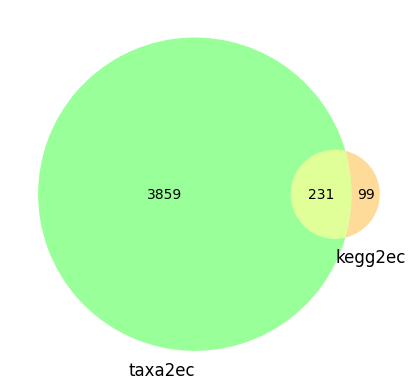

In [3]:
from matplotlib_venn import venn2

venn2(
    subsets=[
        set(taxa2ec_list),
        set(kegg2ec_list)
    ],
    set_labels=[
        "taxa2ec",
        "kegg2ec"
    ],
    set_colors=[
        "lime",
        "orange"
    ]
)

In [4]:
# Make a list of the common ec's between these two lists
set1 = set(taxa2ec_list)
set2 = set(kegg2ec_list)
common = list(set1.intersection(set2))

# Put the list into a dataframe
dict = {'ec': common}
ecs = pd.DataFrame(dict)

In [5]:
# Summing the abundance of enzymes across our taxa related to different enzyme groups
enzyme_df = ecs.value_counts("ec").reset_index().copy() #ecs.value_counts originally
enzyme_df['Group'] = enzyme_df['ec'].apply(lambda x: x.strip().split('.')[0])
grouped_df = enzyme_df.groupby('Group')['count'].sum().reset_index()
grouped_df.columns = ['Group','Total Count']
grouped_df

,Group,Total Count
0,1,147
1,2,55
2,3,23
3,4,4
4,6,2


In [6]:
# Create filler rows for classes which have 0 counts (manual step)
filler_dict = {'Group':[5,7],
        'Total Count':[0,0]
       }

filler = pd.DataFrame(filler_dict)

grouped_df = pd.concat([grouped_df,filler], ignore_index = True).copy()
grouped_df['Group'] = grouped_df['Group'].astype(int)
grouped_df = grouped_df.sort_values('Group')
grouped_df.reset_index()

grouped_df

,Group,Total Count
0,1,147
1,2,55
2,3,23
3,4,4
5,5,0
4,6,2
6,7,0


In [7]:
# Adding information on the type of enzymes (NOTE: no enzymes from class 5 or 7, so removed these labels...could alternatively have a place holder above)
ec_class = ['Oxidoreductases','Transferases','Hydrolases','Lyases','Isomerases','Ligases','Translocases']
grouped_df['Class'] = ec_class

enzyme_counts = grouped_df[['Group','Class','Total Count']]
print(enzyme_counts)

   Group            Class  Total Count
0      1  Oxidoreductases          147
1      2     Transferases           55
2      3       Hydrolases           23
3      4           Lyases            4
5      5       Isomerases            0
4      6          Ligases            2
6      7     Translocases            0


In [12]:
from matplotlib import pyplot as plt
import plotly.express as px

# Plot the occurrence of enzymes across all of our selected taxa 
fig2 = px.bar(enzyme_counts, x="Class", y="Total Count") #, title="Overlap of enzyme classes between taxa and media:"
fig2.show()

In [ ]:
#EC 1: Oxidoreductases – Enzymes that catalyze oxidation-reduction reactions.
#EC 2: Transferases – Enzymes that transfer a functional group (e.g., a methyl or phosphate group).
#EC 3: Hydrolases – Enzymes that catalyze the hydrolysis of various bonds.
#EC 4: Lyases – Enzymes that break various chemical bonds by means other than hydrolysis/oxidation, often forming a new double-bond or ring structure.
#EC 5: Isomerases – Enzymes that catalyze the transfer of groups within molecules to yield isomeric forms.
#EC 6: Ligases – Enzymes that join two molecules together, typically using ATP.
#EC 7: Translocases – Enzymes that catalyze the movement of ions or molecules across membranes or their separation within membranes.